
<a id='odu'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Pesquisa de Emprego III: Pesquisa com Aprendizado

## Conteúdo

- [Pesquisa de Emprego III: Pesquisa com Aprendizado](#Pesquisa-de-Emprego-III:-Pesquisa-com-Aprendizado)  
  - [Resumo](#Resumo)  
  - [O Modelo](#O-Modelo)  
  - [Passo 1: Solução por VFI](#Passo-1:-Solução-por-VFI)  
  - [Passo 2: Um Método Mais Eficiente](#Passo-2:-Um-Método-Mais-Eficiente)  
  - [Exercícios](#Exercícios)  
  - [Soluções](#Soluções)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo 

Nesta aula, consideramos uma extensão do modelo de pesquisa de emprego [estudado anteriormente](https://julia.quantecon.org/mccall_model.html) de McCall [[McC70]](https://julia.quantecon.org/../zreferences.html#mccall1970).

No modelo de McCall, um trabalhador desempregado decide quando aceitar uma posição permanente com um salário especificado, dado:

- Sua taxa de desconto.  
- O nível do seguro desemprego. 
- A distribuição a partir da qual ofertas salariais são retiradas. 


Na versão considerada abaixo, a distribuição salarial é desconhecida e deve ser aprendida.

- O seguinte é baseado na apresentação em [[LS18]](https://julia.quantecon.org/../zreferences.html#ljungqvist2012), seção 6.6.  

### Recursos do Modelo

- Programação dinâmica de horizonte infinito com dois estados e um controle binário. 
- Atualização bayesiana para aprender a distribuição desconhecida. 

### Confiuguração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

## O Modelo


<a id='index-0'></a>
Vamos primeiro revisar o modelo básico de McCall [[McC70]](https://julia.quantecon.org/../zreferences.html#mccall1970) e depois adicionar a variação que queremos considerar.

### O Modelo Básico de McCall


<a id='index-1'></a>
Lembre-se que, [na linha de base do modelo](https://julia.quantecon.org/mccall_model.html), um trabalhador desempregado é apresentado em cada período com uma oferta de emprego permanente com o salário $ W_t $.

No período $ t $, nosso trabalhador também:

1. Aceita a oferta e trabalha permanentemente com salário constante  $ W_t $. 
1. Rejeita a oferta, recebe indenização por desemprego $ c $ e reconsidera o próximo período.


A sequência salárial $ \{W_t\} $ é *iid* e gerada a partir de uma densidade conhecida $ h $.

O trabalhador tem como objetivo maximizar a soma esperada descontada dos ganhos $ \mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t $.
A função $ V $ satisfaz a recursão:


<a id='equation-odu-odu-pv'></a>
$$
V(w)
= \max \left\{
\frac{w}{1 - \beta}, \, c + \beta \int V(w')h(w') dw'
\right\} \tag{1}
$$

A política ótima tem a forma $ \mathbf{1}\{w \geq \bar w\} $, onde
$ \bar w $ é uma constante dependendo do chamado *salário de reserva*.

### Distribuição de Oferta Desconhecida

Agora vamos estender o modelo considerando a variação apresentada em [[LS18]](https://julia.quantecon.org/../zreferences.html#ljungqvist2012), seção 6.6.

O modelo é como acima, além do fato de que:

- A densidade $ h $ é desconhecida.
- O trabalhador aprende sobre $ h $ começando com uma prévia e atualizando com base nas ofertas salariais que ele/ela observa.

O trabalhador sabe que existem duas distribuições possíveis $ F $ e $ G $ — com densidades $ f $ e $ g $.

No inicio do período, a “natureza” seleciona $ h $ a ser $ f $ ou
$ g $ — a distribuição salarial a partir da qual toda a sequência $ \{W_t\} $ será extraida.

Essa escolha não é observada pelo trabalhador, que coloca a probabilidade anterior $ \pi_0 $ em $ f $ sendo escolhido.

Regra de atualização: o tempo $ t $ do trabalhador estimado da distribuição é $ \pi_t f + (1 - \pi_t) g $, onde $ \pi_t $ atualiza via: 


<a id='equation-odu-pi-rec'></a>
$$
\pi_{t+1}
= \frac{\pi_t f(w_{t+1})}{\pi_t f(w_{t+1}) + (1 - \pi_t) g(w_{t+1})} \tag{2}
$$

Essa última expressão segue a regra de Bayes, que nos diz que:

$$
\mathbb{P}\{h = f \,|\, W = w\}
= \frac{\mathbb{P}\{W = w \,|\, h = f\}\mathbb{P}\{h = f\}}
{\mathbb{P}\{W = w\}}
\quad \text{and} \quad
\mathbb{P}\{W = w\} = \sum_{\psi \in \{f, g\}} \mathbb{P}\{W = w \,|\, h = \psi\} \mathbb{P}\{h = \psi\}
$$

O fato de [(2)](#equation-odu-pi-rec) ser recursivo nos permite avançar para um método de solução recursiva.

fazendo,

$$
h_{\pi}(w) := \pi f(w) + (1 - \pi) g(w)
\quad \text{e} \quad
q(w, \pi) := \frac{\pi f(w)}{\pi f(w) + (1 - \pi) g(w)}
$$

podemos expressar recursivamente a função de valor para o trabalhador desempregado da seguinte maneira:


<a id='equation-odu-mvf'></a>
$$
V(w, \pi)
= \max \left\{
\frac{w}{1 - \beta}, \, c + \beta \int V(w', \pi') \, h_{\pi}(w') \, dw'
\right\}
\quad \text{where} \quad
\pi' = q(w', \pi) \tag{3}
$$

Observe que a suposição atual $ \pi $ é um estado variável, pois afeta a percepção das probabilidades do trabalhador em relação a recompensas futuras.

### Parametrização
Seguindo a seção 6.6 de [[LS18]](https://julia.quantecon.org/../zreferences.html#ljungqvist2012), nossa linha de base para parametrização será:

- $ f $ é $ \operatorname{Beta}(1, 1) $ escalado (ou seja, as extrações são multiplicadas por) algum fator $ w_m $. 
- $ g $ é $ \operatorname{Beta}(3, 1.2) $ escalado (ou seja, as extrações são multiplicadas por) o mesmo fator $ w_m $.
- $ \beta = 0.95 $ e $ c = 0.6 $. 


Com $ w_m = 2 $, as densidades $ f $ e $ g $ possuem o seguinte formato:

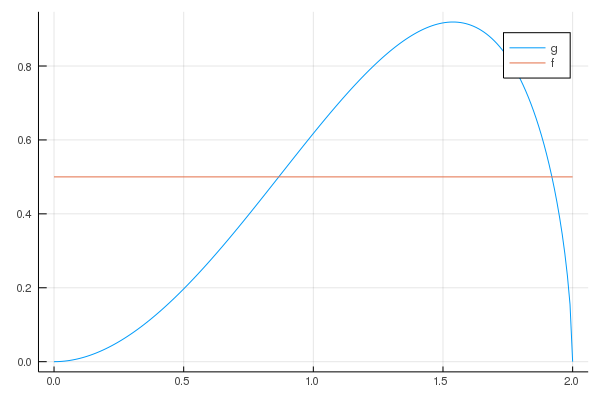

In [2]:
using LinearAlgebra, Statistics
using Distributions, Plots, QuantEcon, Interpolations, Parameters

gr(fmt=:png);

w_max = 2
x = range(0,  w_max, length = 200)

G = Beta(3, 1.6)
F = Beta(1, 1)
plot(x, pdf.(G, x/w_max)/w_max, label="g")
plot!(x, pdf.(F, x/w_max)/w_max, label="f")


<a id='looking-forward'></a>

### Olhando para Frente

Que tipo de política ideal pode resultar de [(3)](#equation-odu-mvf) e a parametrização especificada acima?

Intuitivamente, se aceitarmos que $ w_a $ e $ w_a \leq w_b $, então — com todas as outras coisas sendo dadas - também devemos aceitar em $ w_b $.

Isto sugere uma política de aceitar sempre que $ w $ exceder algum valor de limite $ \bar w $.

Mas $ \bar w $ deve depender de $ \pi $ — de fato, deveria estar diminuindo em $ \pi $ porque:

- $ f $ é uma distribuição de oferta menos atraente que $ g $.
- quão maior $ \pi $ significa mais peso em $ f $ e menos em $ g $. 


Então quão maior $ \pi $ deprime a avaliação das perspectivas futuras do trabalhador e as ofertas atuais relativamente baixas tornam-se mais atraentes.

**Resumo:** conjecturamos que a política ideal é da forma
$ \mathbb 1 \{w \geq \bar w(\pi) \} $ para alguma função decrescente
$ \bar w $.

## Passo 1: Solução por VFI

Vamos começar a resolver o modelo e ver como nossos resultados correspondem à nossa intuição.

Começamos resolvendo por meio da iteração de função de valor (VFI), que é natural, mas acaba sendo a segunda melhor.

O código é o seguinte:


<a id='odu-vfi-code'></a>

In [3]:
# use a palavra chave argument
function SearchProblem(;β = 0.95, c = 0.6, F_a = 1, F_b = 1,
                       G_a = 3, G_b = 1.2, w_max = 2.0,
                       w_grid_size = 40, π_grid_size = 40)

    F = Beta(F_a, F_b)
    G = Beta(G_a, G_b)

    # fdps escaladas
    f(x) = pdf.(F, x/w_max)/w_max
    g(x) = pdf.(G, x/w_max)/w_max

    π_min = 1e-3  # evita instabilidade
    π_max = 1 - π_min

    w_grid = range(0,  w_max, length = w_grid_size)
    π_grid = range(π_min,  π_max, length = π_grid_size)

    nodes, weights = qnwlege(21, 0.0, w_max)

    return (β = β, c = c, F = F, G = G, f = f,
            g = g, n_w = w_grid_size, w_max = w_max,
            w_grid = w_grid, n_π = π_grid_size, π_min = π_min,
            π_max = π_max, π_grid = π_grid, quad_nodes = nodes,
            quad_weights = weights)
end

function q(sp, w, π_val)
    new_π = 1.0 / (1 + ((1 - π_val) * sp.g(w)) / (π_val * sp.f(w)))

    # Retorna new_π quando [π_min, π_max] e pontos fixos
    return clamp(new_π, sp.π_min, sp.π_max)
end

function T!(sp, v, out;
                           ret_policy = false)
    # simplificando os nomes
    @unpack f, g, β, c = sp
    nodes, weights = sp.quad_nodes, sp.quad_weights

    vf = extrapolate(interpolate((sp.w_grid, sp.π_grid), v,
                    Gridded(Linear())), Flat())

    # configurar a quadratura nodes/weights
    # q_nodes, q_weights = qnwlege(21, 0.0, sp.w_max)

    for (w_i, w) in enumerate(sp.w_grid)
        # calcular v1
        v1 = w / (1 - β)

        for (π_j, _π) in enumerate(sp.π_grid)
            # calcular v2
            integrand(m) = [vf(m[i], q.(Ref(sp), m[i], _π)) *
                        (_π * f(m[i]) + (1 - _π) * g(m[i])) for i in 1:length(m)]
            integral = do_quad(integrand, nodes, weights)
            # integral = do_quad(integrand, q_nodes, q_weights)
            v2 = c + β * integral

            # returna a política se pedido, caso contrário retorna máximo dos valores 
            out[w_i, π_j] = ret_policy ? v1 > v2 : max(v1, v2)
        end
    end
    return out
end

function T(sp, v;
                          ret_policy = false)
    out_type = ret_policy ? Bool : Float64
    out = zeros(out_type, sp.n_w, sp.n_π)
    T!(sp, v, out, ret_policy=ret_policy)
end


get_greedy!(sp, v, out) = T!(sp, v, out, ret_policy = true)

get_greedy(sp, v) = T(sp, v, ret_policy = true)

function res_wage_operator!(sp, ϕ, out)
    # simplificando os nomes
    @unpack f, g, β, c = sp

    # Construindo o interpolador sobre π_grid, dado ϕ 
    ϕ_f = LinearInterpolation(sp.π_grid, ϕ, extrapolation_bc = Line())

    # configuração da quadratura nodes/weights
    q_nodes, q_weights = qnwlege(7, 0.0, sp.w_max)

    for (i, _π) in enumerate(sp.π_grid)
        integrand(x) = max.(x, ϕ_f.(q.(Ref(sp), x, _π))) .* (_π * f(x) + (1 - _π) * g(x))
        integral = do_quad(integrand, q_nodes, q_weights)
        out[i] = (1 - β) * c + β * integral
    end
end

function res_wage_operator(sp, ϕ)
    out = similar(ϕ)
    res_wage_operator!(sp, ϕ, out)
    return out
end

res_wage_operator (generic function with 1 method)

O tipo `SearchProblem` é usado para armazenar parâmetros e métodos necessários para calcular as ações ideais.

O operador Bellman é implementado como o método `T()`, enquanto `get_greedy()`
calcula uma política ótima aproximada a partir de uma estimativa `v` da função de valor.

Omitiremos uma discussão detalhada do código porque existe um método de solução mais eficiente.

Essas idéias são implementadas no método `.res_wage_operator()`.

Antes de explicá-lo, vamos olhar para as soluções calculadas a partir da iteração da função de valor.

Aqui está a função de valor:

Compute iterate 10 with error 0.19801710153283736
Compute iterate 20 with error 0.007608221868107279
Compute iterate 30 with error 0.0002901698734376623
Converged in 34 steps


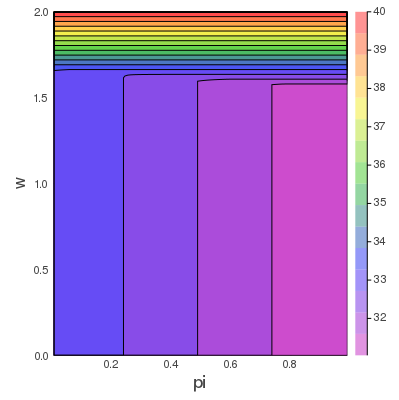

In [4]:
# Configure o problema e a suposição inicial, resolva por VFI 
sp = SearchProblem(;w_grid_size=100, π_grid_size=100)
v_init = fill(sp.c / (1 - sp.β), sp.n_w, sp.n_π)
f(x) = T(sp, x)
v = compute_fixed_point(f, v_init)
policy = get_greedy(sp, v)

# faça funções para os interpolantes lineares destes 
vf = extrapolate(interpolate((sp.w_grid, sp.π_grid), v, Gridded(Linear())),
                Flat())
pf = extrapolate(interpolate((sp.w_grid, sp.π_grid), policy,
                Gridded(Linear())), Flat())

function plot_value_function(;w_plot_grid_size = 100,
                            π_plot_grid_size = 100)
  π_plot_grid = range(0.001,  0.99, length =  π_plot_grid_size)
  w_plot_grid = range(0,  sp.w_max, length = w_plot_grid_size)
  Z = [vf(w_plot_grid[j], π_plot_grid[i])
          for j in 1:w_plot_grid_size, i in 1:π_plot_grid_size]
  p = contour(π_plot_grid, w_plot_grid, Z, levels=15, alpha=0.6,
              fill=true, size=(400, 400), c=:lightrainbow)
  plot!(xlabel="pi", ylabel="w", xguidefont=font(12))
  return p
end

plot_value_function()


<a id='odu-pol-vfi'></a>
A política ótima:

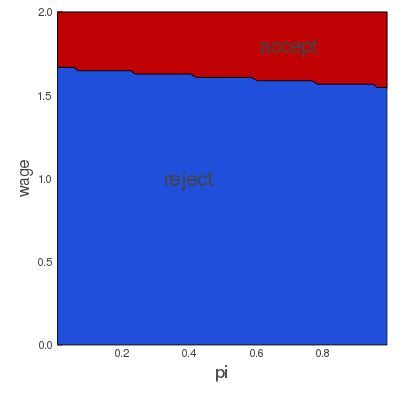

In [5]:
function plot_policy_function(;w_plot_grid_size = 100,
                              π_plot_grid_size = 100)
    π_plot_grid = range(0.001,  0.99, length = π_plot_grid_size)
    w_plot_grid = range(0,  sp.w_max, length = w_plot_grid_size)
    Z = [pf(w_plot_grid[j], π_plot_grid[i])
            for j in 1:w_plot_grid_size, i in 1:π_plot_grid_size]
    p = contour(π_plot_grid, w_plot_grid, Z, levels=1, alpha=0.6, fill=true,
                size=(400, 400), c=:coolwarm)
    plot!(xlabel="pi", ylabel="wage", xguidefont=font(12), cbar=false)
    annotate!(0.4, 1.0, "reject")
    annotate!(0.7, 1.8, "accept")
    return p
end

plot_policy_function()

O código leva vários minutos para ser executado.

Os resultados se encaixam bem com a nossa intuição da seção [Olhando para Frente](#looking-forward).

- A linha preta na figura acima corresponde à função  $ \bar w(\pi) $ introduzida lá.  
- Está diminuindo conforme o esperado. 

## Passo 2: Um Método Mais Eficiente

Nossa implementação do VFI pode ser otimizada até certo ponto.

Mas, em vez de buscar isso, vamos considerar outro método para resolver a política ideal.

Usaremos a iteração com um operador que tenha a mesma taxa de contração do operador Bellman, mas:

- unidimensional em vez de bidimensional.
- nenhuma etapa de maximização.


Como consequência, o algoritmo é de ordens de magnitude mais rápidas que o VFI.

Esta seção ilustra o ponto em que, quando se trata de programação, um pouco de análise matemática é bastante útil.

### Outra Equação Funcional

Para começar, note que quando $ w = \bar w(\pi) $, o trabalhador é indiferente entre aceitar e rejeitar.

Portanto, as duas opções no lado direito de [(3)](#equation-odu-mvf) tem valores iguais:


<a id='equation-odu-mvf2'></a>
$$
\frac{\bar w(\pi)}{1 - \beta}
= c + \beta \int V(w', \pi') \, h_{\pi}(w') \, dw' \tag{4}
$$

Juntos, [(3)](#equation-odu-mvf) e [(4)](#equation-odu-mvf2) dão,


<a id='equation-odu-mvf3'></a>
$$
V(w, \pi) =
\max
\left\{
    \frac{w}{1 - \beta} ,\, \frac{\bar w(\pi)}{1 - \beta}
\right\} \tag{5}
$$

Combinando [(4)](#equation-odu-mvf2) e [(5)](#equation-odu-mvf3), obtemos:

$$
\frac{\bar w(\pi)}{1 - \beta}
= c + \beta \int \max \left\{
    \frac{w'}{1 - \beta} ,\, \frac{\bar w(\pi')}{1 - \beta}
\right\}
\, h_{\pi}(w') \, dw'
$$

Multiplicando por $ 1 - \beta $, substituindo em $ \pi' = q(w', \pi) $ e usando $ \circ $ para compor as funções, tem-se:


<a id='equation-odu-mvf4'></a>
$$
\bar w(\pi)
= (1 - \beta) c +
\beta \int \max \left\{ w', \bar w \circ q(w', \pi) \right\} \, h_{\pi}(w') \, dw' \tag{6}
$$

A equação [(6)](#equation-odu-mvf4) pode ser entendida como uma equação funcional, onde $ \bar w $ é uma função desconhecida.

- Vamos chamá-lo de *equação funcional do salário de reserva* (RWFE).  
- A solução $ \bar w $ para o RWFE é o objetivo que desejamos computar.  

### Resolvendo o RWFE

Para resolver o RWFE, primeiro mostraremos que sua solução é o ponto fixo de um [mapeamento de contração](https://en.wikipedia.org/wiki/Contraction_mapping).

Para esse fim, fazemos:

- $ b[0,1] $ sejam as funções de valor real delimitadas por $ [0,1] $.
- $ \| \psi \| := \sup_{x \in [0,1]} | \psi(x) | $ 


Considere o operador $ Q $ mapeando $ \psi \in b[0,1] $ em $ Q\psi \in b[0,1] $ via:


<a id='equation-odu-dq'></a>
$$
(Q \psi)(\pi)
= (1 - \beta) c +
\beta \int \max \left\{ w', \psi \circ q(w', \pi) \right\} \, h_{\pi}(w') \, dw' \tag{7}
$$

Comparando [(6)](#equation-odu-mvf4) e [(7)](#equation-odu-dq), vemos que o conjunto de pontos fixos de $ Q $ exatamente coincide com o conjunto de soluções do RWFE.

- Se $ Q \bar w = \bar w $ então $ \bar w $ resolve [(6)](#equation-odu-mvf4) e vice-versa.  


Além disso, para qualquer $ \psi, \phi \in b[0,1] $, a álgebra básica e a desigualdade de triângulo para integrais nos dizem que:


<a id='equation-odu-nt'></a>
$$
|(Q \psi)(\pi) - (Q \phi)(\pi)|
\leq \beta \int
\left|
\max \left\{w', \psi \circ q(w', \pi) \right\} -
\max \left\{w', \phi \circ q(w', \pi) \right\}
\right|
\, h_{\pi}(w') \, dw' \tag{8}
$$

Trabalhando caso por caso, é fácil verificar que para números reais $ a, b, c $ sempre temos,


<a id='equation-odu-nt2'></a>
$$
| \max\{a, b\} - \max\{a, c\}| \leq | b - c| \tag{9}
$$

Combinando [(8)](#equation-odu-nt) e [(9)](#equation-odu-nt2) produz:


<a id='equation-odu-nt3'></a>
$$
|(Q \psi)(\pi) - (Q \phi)(\pi)|
\leq \beta \int
\left| \psi \circ q(w', \pi) -  \phi \circ q(w', \pi) \right|
\, h_{\pi}(w') \, dw'
\leq \beta \| \psi - \phi \| \tag{10}
$$

Tomando o supremo sobre $ \pi $ agora nos dá,


<a id='equation-odu-rwc'></a>
$$
\|Q \psi - Q \phi\|
\leq \beta \| \psi - \phi \| \tag{11}
$$

Em outras palavras, $ Q $ é uma contração do módulo $ \beta $ no espaço métrico completo $ (b[0,1], \| \cdot \|) $.

Portando:

- Uma única solução $ \bar w $ para o RWFE existe em $ b[0,1] $.  
- $ Q^k \psi \to \bar w $ uniformemente como $ k \to \infty $, para qualquer $ \psi \in b[0,1] $.  

#### Implementatição

Essas idéias são implementadas no método `.res_wage_operator()` do `odu.jl` como mostrado acima.

O método corresponde à ação do operador $ Q $.

O exercício a seguir solicita que você explore esses fatos para calcular uma aproximação de $ \bar w $.

## Exercícios


<a id='odu-ex1'></a>

### Exercício 1

Use os parâmetros padrão e o método `.res_wage_operator()` para computar uma política ótima.

Seu resultado deve coincidir com o valor da política ideal [mostrado acima](#odu-pol-vfi).

Tente experimentar diferentes parâmetros e confirme se a alteração na política ideal coincide com a sua intuição.

## Soluções

### Exercício 1

Esse código resolve o modelo "Distribuição desconhecida da oferta" repetindo uma suposição da função de salário de reserva. Você deve achar que o tempo de execução é muito menor que o da abordagem da função de valor
`examples/odu_vfi_plots.jl`.

Compute iterate 10 with error 0.007194437603255555
Compute iterate 20 with error 0.0004348703417873523
Converged in 26 steps


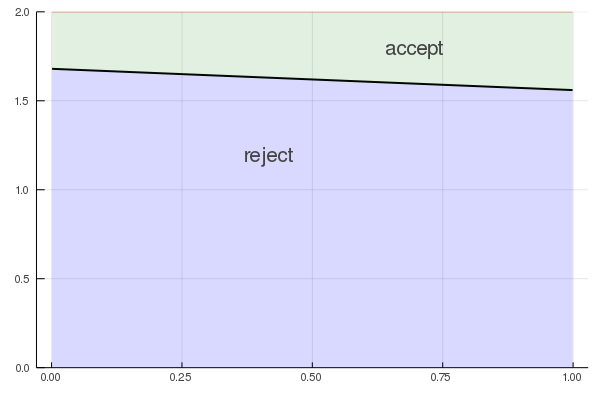

In [6]:
sp = SearchProblem(π_grid_size = 50)

ϕ_init = ones(sp.n_π)
f_ex1(x) = res_wage_operator(sp, x)
w̄ = compute_fixed_point(f_ex1, ϕ_init)

plot(sp.π_grid, w̄, linewidth = 2, color=:black,
     fillrange = 0, fillalpha = 0.15, fillcolor = :blue)
plot!(sp.π_grid, 2 * ones(length(w̄)), linewidth = 0, fillrange = w̄,
      fillalpha = 0.12, fillcolor = :green, legend = :none)
plot!(ylims = (0, 2), annotations = [(0.42, 1.2, "reject"),
                                     (0.7, 1.8, "accept")])

O próximo trecho de código não é um dos exercícios do QuantEcon - é apenas uma simulação divertida para ver qual é o efeito de uma mudança na distribuição subjacente na taxa de desemprego.

Em um ponto da simulação, a distribuição se torna significativamente pior. Demora um tempo para os agentes aprenderem isso e, enquanto isso, eles são otimistas demais e recusam muitos empregos. Como resultado, a taxa de desemprego aumenta.

O código leva alguns minutos para ser executado.

Compute iterate 10 with error 0.007194437603255555
Compute iterate 20 with error 0.0004348703417873523
Converged in 26 steps
date = 20
date = 40
date = 60
date = 80
date = 100
date = 120
date = 140
date = 160
date = 180
date = 200
date = 220
date = 240
date = 260
date = 280
date = 300
date = 320
date = 340
date = 360
date = 380
date = 400
date = 420
date = 440
date = 460
date = 480
date = 500
date = 520
date = 540
date = 560
date = 580
date = 600


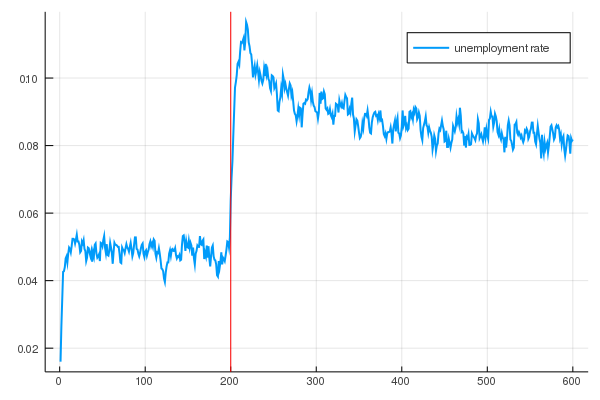

In [7]:
# Determinismo e objetos aleatórios.
using Random
Random.seed!(42)

# Configure o modelo e calcule a função w̄
sp = SearchProblem(π_grid_size = 50, F_a = 1, F_b = 1)
ϕ_init = ones(sp.n_π)
g(x) = res_wage_operator(sp, x)
w̄_vals = compute_fixed_point(g, ϕ_init)
w̄ = extrapolate(interpolate((sp.π_grid, ), w̄_vals,
                    Gridded(Linear())), Flat())

# Mantém o estado de emprego e crenças de um agente individual. 
mutable struct Agent{TF <: AbstractFloat, TI <: Integer}
    _π::TF
    employed::TI
end

Agent(_π=1e-3) = Agent(_π, 1)

function update!(ag, H)
    if ag.employed == 0
        w = rand(H) * 2   # explica a escala em julia
        if w ≥ w̄(ag._π)
            ag.employed = 1
        else
            ag._π = 1.0 ./ (1 .+ ((1 - ag._π) .* sp.g(w)) ./ (ag._π * sp.f(w)))
        end
    end
    nothing
end

num_agents = 5000
separation_rate = 0.025  # Fração de postos de trabalho que terminam em cada período
separation_num = round(Int, num_agents * separation_rate)
agent_indices = collect(1:num_agents)
agents = [Agent() for i=1:num_agents]
sim_length = 600
H = sp.G                 # Começa com a distribuição G
change_date = 200        # Altere para F depois de muitos períodos 
unempl_rate = zeros(sim_length)

for i in 1:sim_length
    if i % 20 == 0
        println("date = $i")
    end

    if i == change_date
        H = sp.F
    end

    # Selecione aleatoriamente agentes de separation_num e defina o status de emprego como 0 
    shuffle!(agent_indices)
    separation_list = agent_indices[1:separation_num]

    for agent in agents[separation_list]
        agent.employed = 0
    end

    # atualize os agentes
    for agent in agents
        update!(agent, H)
    end
    employed = Int[agent.employed for agent in agents]
    unempl_rate[i] = 1.0 - mean(employed)
end

plot(unempl_rate, linewidth = 2, label = "unemployment rate")
vline!([change_date], color = :red, label = "")